```{eval-rst}
.. include:: ../sinebow.rst

```
{header-2}`Multiple channels`
=============================
Omnipose inherits the capability of Cellpose to segment based on multi-channel images. We will use this as an opportunity to show how we can run several models at once on the same image(s), in this case comparing Omnipose to Cellpose trained on the cyto2 dataset. 

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# First, import dependencies.
import numpy as np
import time, os, sys
from cellpose_omni import models, core, utils


# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if 
# you are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# for plotting 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from omnipose.plot import imshow, colorize

2023-08-08 22:33:14,988 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? 1


## Load file
This is one of the images from the cyto2 test dataset. Note that it is a good idea to always work with lists, even when the list of images is 1 long. It allows you to reuse your code easily when you do have a larger set of images to process. 

In [ ]:
from urllib.parse import urlparse
import skimage.io


urls = ['http://www.cellpose.org/static/images/img02.png']
files = []
for url in urls:
    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)
    
imgs = [skimage.io.imread(f) for f in files]
imgs = [np.stack((im[...,-1],im[...,1])) for im in imgs] # put cytosol in 1st channel, nucleus in 2nd
nimg = len(imgs)

Read in the images from the file list. It's a good idea to display the images before proceeding. 

img shape: (2, 349, 467)


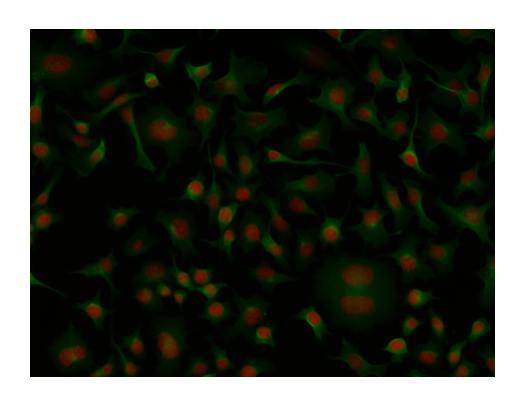

In [ ]:
from cellpose_omni import io, transforms 

# print some infor about the images 
for i in imgs:
    print('img shape:',i.shape)
nimg = len(imgs)
# print(nimg)

colors = np.array([[1,0,0],[0,1,0]])*1.0
for k in range(len(imgs)):
    imgs[k] = transforms.normalize99(imgs[k],omni=True)
    rgb = colorize(imgs[k],colors=colors)    
    imshow(rgb) 

## Initialize models
We will compare two models here: cyto2 (Cellpose) and cyto2_omni. The latter was trained via the following command: 
```
python -m cellpose --train --use_gpu --dir /home/kcutler/DataDrive/cyto2/train --mask_filter _masks --n_epochs 4000 --pretrained_model None  --learning_rate 0.1 --diameter 36 --save_every 50 --save_each --omni --verbose --chan 1 --chan2 2 --RAdam --batch_size 16 --img_filter _img
```

In [ ]:
model_name = ['cyto2','cyto2_omni']
L = len(model_name)
model = [models.CellposeModel(gpu=use_GPU, model_type=m) for m in model_name]

2023-08-08 22:33:18,386 [INFO] >>cyto2<< model set to be used
2023-08-08 22:33:18,387 [INFO] ** TORCH GPU version installed and working. **
2023-08-08 22:33:18,388 [INFO] >>>> using GPU
2023-08-08 22:33:18,431 [INFO] >>cyto2_omni<< model set to be used
2023-08-08 22:33:18,432 [INFO] ** TORCH GPU version installed and working. **
2023-08-08 22:33:18,432 [INFO] >>>> using GPU


## Run segmentation 
The channels input can be very confusing. In the Cellpose documentation, it is stated that the list `[chan,chan2]` should represent the main channel to segment (`chan`) and the optional nuclear channel (`chan2`). But to train via CLI, `chan` is the "channel to segment" and `chan2` is the nuclear channel, and the Cellpose team states the CLI command used to train their model used `--chan 2 --chan2 1`. Because 0 is grayscale and 1,2,3 are R,G,B (note the 1-based indexing here) this means that the given training command actually trains with G cytosol and R nuclei. This might imply that the cyto2_omni model actually is trained 'incorrectly', if I understood this right. 

On top of this, the downloaded image has nuclei in channel 2 and cytosol in channel 1 (blue and green, respectively), whereas the cyto2 dataset shows cytosol as channel 0 and nuclei as channel 1 (this may be a result of using OpenCV, which usies BGR by default instead of RGB). So in fact, I should have trained the cyto2_omni model with `--chan 1 --chan2 2`. (Have not yet done this with most recent models...) Keep this in mind as you train your own models. 



```{note}
You can train Omnipose on arbitrary numbers of channels using the `--all_channels` parameter. The reason for the cyto* models being trained with two channel was to focus on eukaryotes with cytosol and nuclei tags while also including many other images that might be single-channel. The chan, chan2 arguments and corresponding code in Cellpose is thus highly specific to this use case. Omnipose should probably always be trained with `--all_channels` on a dataset with the same number of channels across all images. After training, initialize the model with `nchan=nchan` and evaluate using `chans=None`. 

```

For now, the following shows what channel arguments you need for the provided cyto2 models:

In [ ]:
chans = [[2,1],[1,2]] # green cytoplasm [2] and red nucleus [1], see above 
n = range(nimg) 

# define parameters
mask_threshold = [-1,-1,-1] #new model might need a bit lower 
verbose =0 # turn on if you want to see more output 
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale= None # give this a number if you need to upscale or downscale your images
flow_threshold = 0 # default is .4, but only needed if there are spurious masks to clean up; slows down output
resample = False #whether or not to run dynamics on rescaled grid or original grid 

N = L+1 # three options: pure cellpose, mixed, omnipose, new omnipose
omni = [0,1,1]
ind = [0,0,1]
masks, flows, styles = [[]]*N, [[]]*N, [[]]*N

diameter = 30
for i in range(N):
    masks[i], flows[i], styles[i] = model[ind[i]].eval([imgs[i] for i in n],channels=chans[ind[i]],
                                                       diameter=diameter,
                                                       mask_threshold=mask_threshold[i],
                                                       transparency=transparency,
                                                       flow_threshold=flow_threshold,
                                                       omni=omni[i], #toggle omni
                                                       resample=resample,verbose=verbose, 
                                                       cluster=omni[i],
                                                       interp=True, tile=False)

## Plot the results

model: cyto2, omni: 0


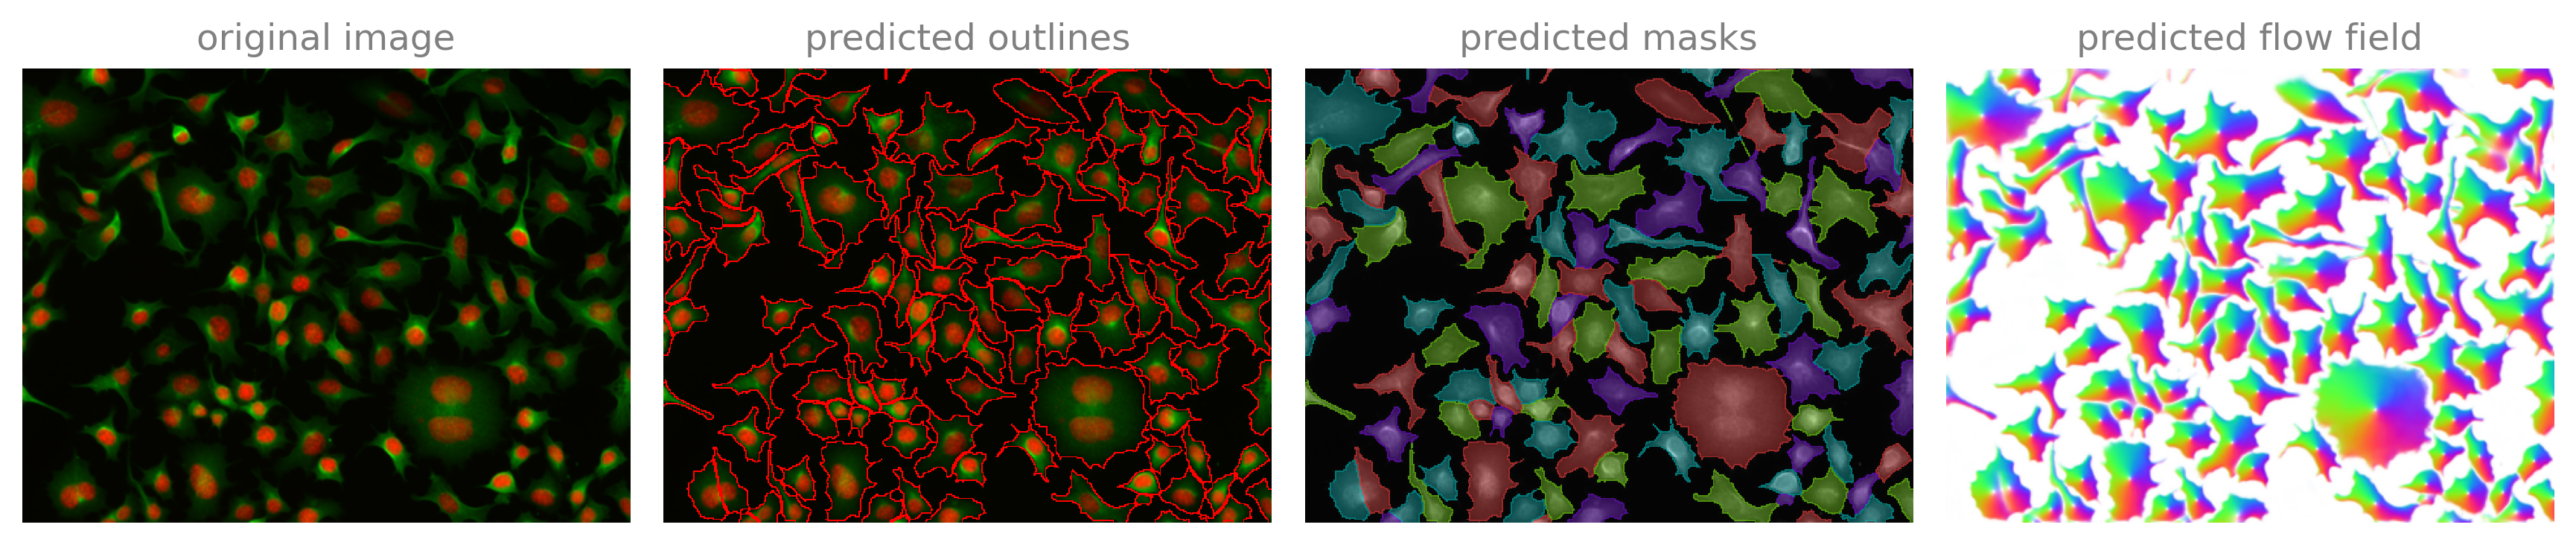

model: cyto2, omni: 0


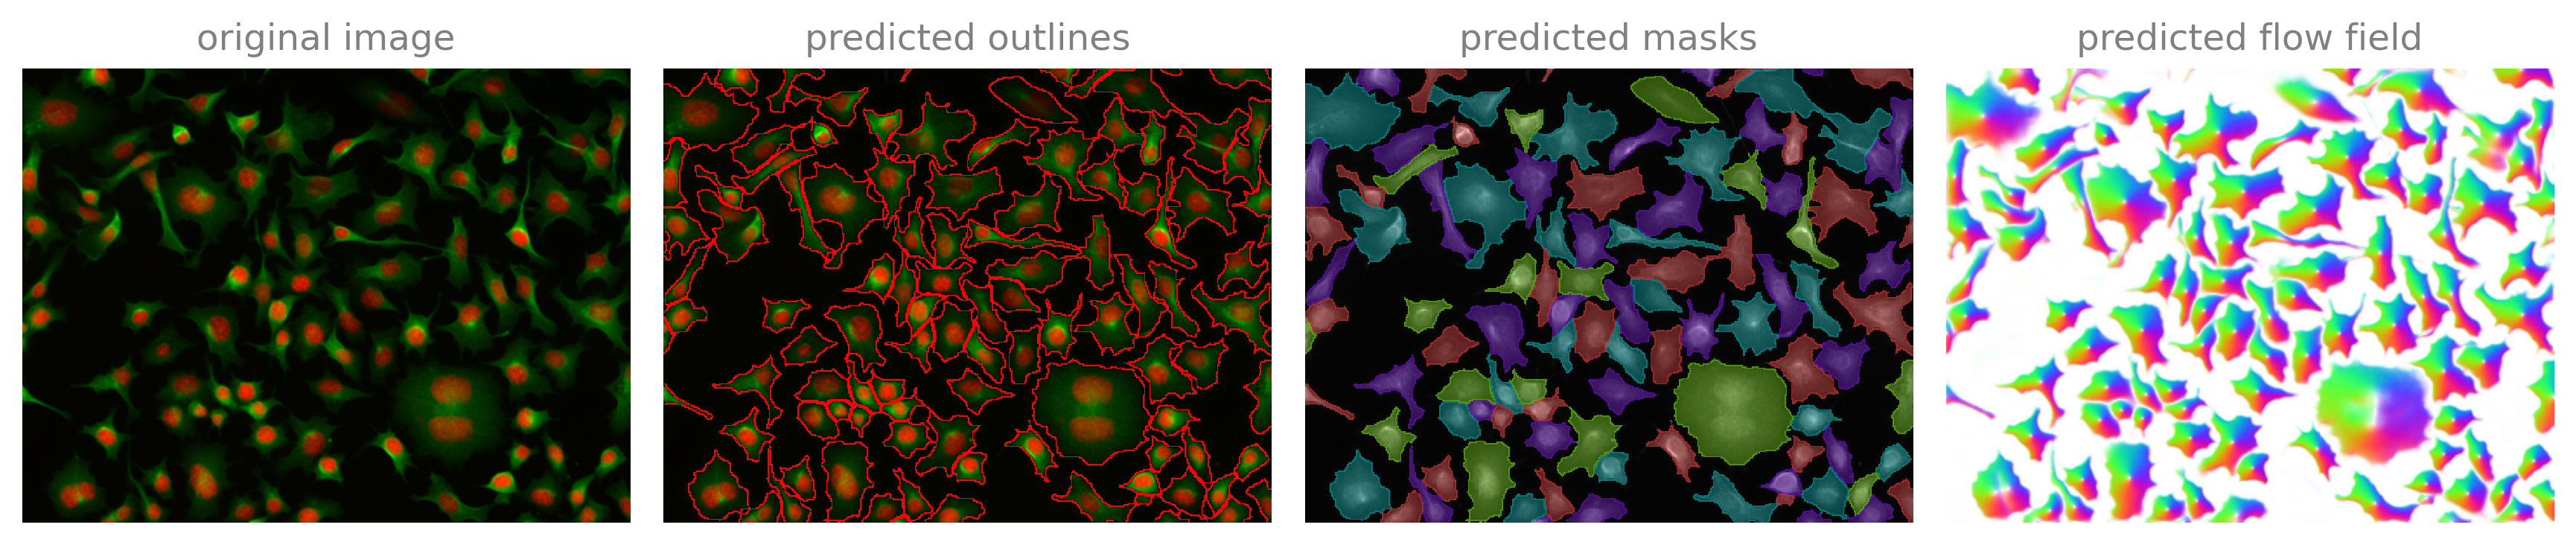

model: cyto2_omni, omni: 1


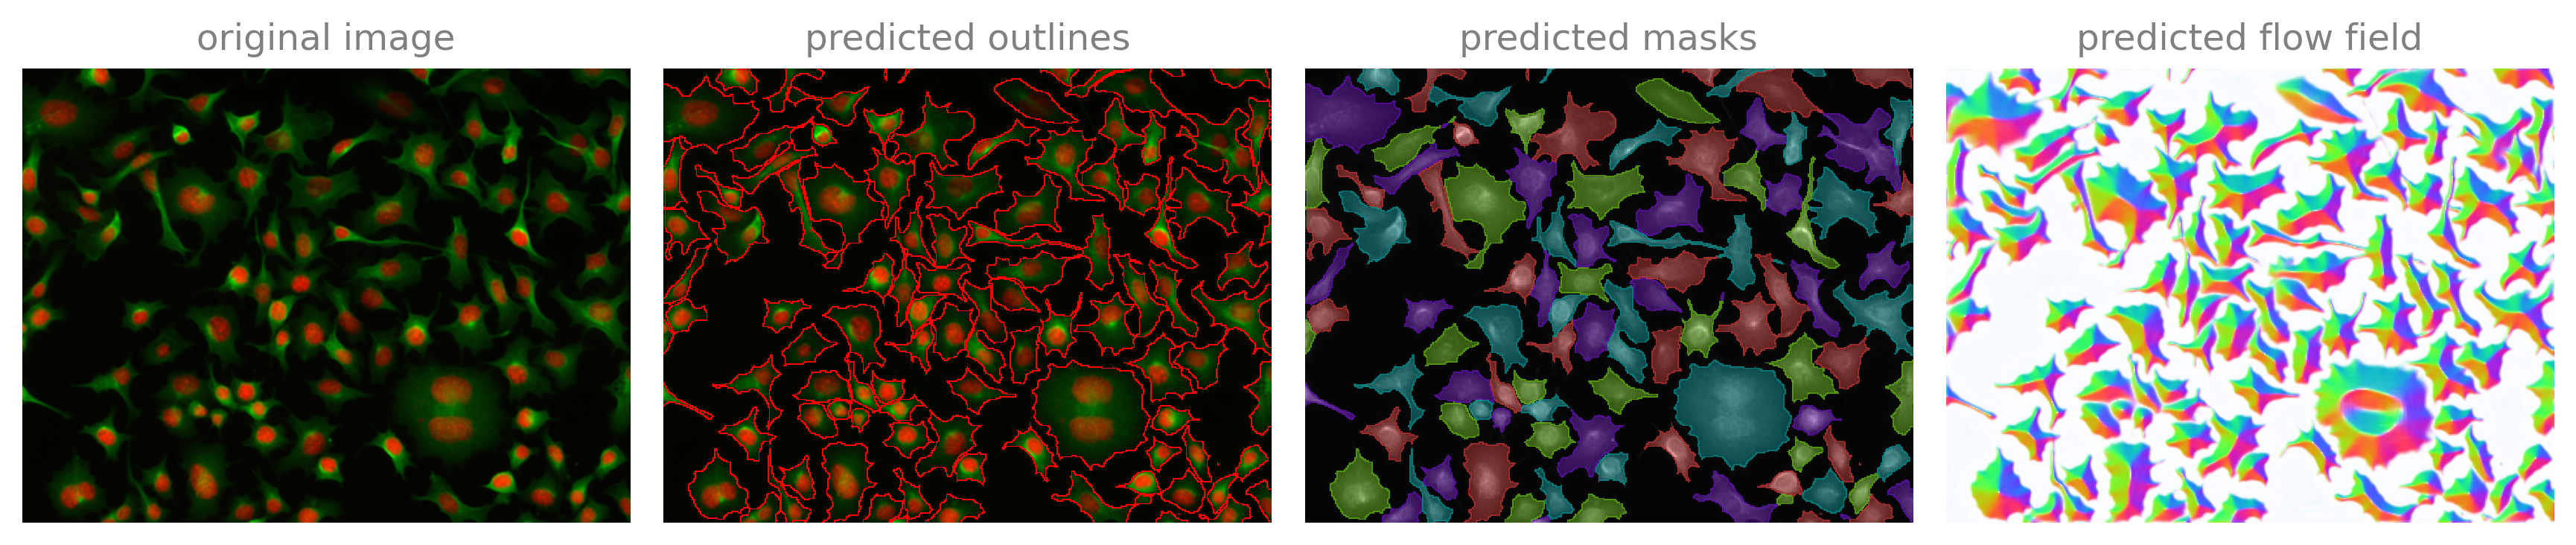

In [ ]:
from cellpose_omni import plot
import omnipose

for idx,i in enumerate(n):
    
    for k,ki in enumerate(ind):
        
        print('model: {}, omni: {}'.format(model_name[ki],omni[ki]))
        maski = masks[k][idx] # get masks
        flowi = flows[k][idx][0] # get RGB flows
        
        # set up the output figure to better match the resolution of the images 
        f = 10
        szX = maski.shape[-1]/mpl.rcParams['figure.dpi']*f
        szY = maski.shape[-2]/mpl.rcParams['figure.dpi']*f
        fig = plt.figure(figsize=(szY,szX*4))
        fig.patch.set_facecolor([0]*4)

        plot.show_segmentation(fig, 
                               omnipose.utils.normalize99(imgs[i]),
                               maski, flowi, 
                               channels=chans[i], 
                               channel_axis=1,
                               omni=True,
                               img_colors=colors,
                       interpolation=None)

        plt.tight_layout()
        plt.show()

Some comments on the above: Omnipose pre-processes the images slightly differently (see `normalize99`) and therefore the flow is a bit different even with the same model and input image compared to stock Cellpose. The `cluster` option helps a lot to get accurate masks with Omnipose in thin regions, but can result in under-segmentation between cells with poorly-defined flow fields. This can be a weakness of Omnipose relative to Cellpose, but as seen in the paper, Omnipose does slightly better than Cellpose on the cyto2 dataset on average. On roundish and low-accuracy datasets like cyto2, Omnipose simply does better in some areas and worse in others. 